In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import random

train_file_path = "train.csv"
df_train = pd.read_csv(train_file_path)

#Clasificamos los precios por cuartiles 
q1 = df_train['SalePrice'].quantile(0.25)
q3 = df_train['SalePrice'].quantile(0.75)

df_train['PriceCategory'] = pd.cut(df_train['SalePrice'], bins=[-np.inf, q1, q3, np.inf], labels=['Económicas', 'Intermedias', 'Caras'])


# Variable dicotómica
df_train['Es_Economica'] = (df_train['PriceCategory'] == 'Económicas').astype(int)
df_train['Es_Media'] = (df_train['PriceCategory'] == 'Intermedias').astype(int)
df_train['Es_Cara'] = (df_train['PriceCategory'] == 'Caras').astype(int)

print(df_train[['Es_Economica', 'Es_Media', 'Es_Cara']].head())



   Es_Economica  Es_Media  Es_Cara
0             0         1        0
1             0         1        0
2             0         0        1
3             0         1        0
4             0         0        1


In [5]:
from sklearn.preprocessing import StandardScaler
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Variable objetivo
y = df_train['Es_Cara']

# Selección de características predictoras (ejemplo: todas las numéricas excepto las creadas)
X = df_train.select_dtypes(include=np.number).drop(['Es_Cara', 'Es_Economica', 'Es_Media'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state, stratify=y
)

model = LogisticRegression(max_iter=1000)

# Reemplazar infinitos por NaN y luego eliminar filas con NaNs
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna()
y = y.loc[X.index]  # Alinear y con X después de eliminar filas

# Eliminar columnas con varianza 0 (constantes)
X = X.loc[:, X.std() > 0]



scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Validación cruzada con 5 folds
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=random_state, stratify=y
)

modeel = LogisticRegression(max_iter=1000)

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')

print("Precisión media con validación cruzada:", cv_scores.mean())


# Entrenar modelo con todo el set de entrenamiento
model.fit(X_train, y_train)

# Predicciones en test
y_pred = model.predict(X_test)

# Evaluación
print("Reporte de clasificación en test:")
print(classification_report(y_test, y_pred))

print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


Precisión media con validación cruzada: 0.9642658827372204
Reporte de clasificación en test:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       249
           1       0.99      0.94      0.97        88

    accuracy                           0.98       337
   macro avg       0.98      0.97      0.98       337
weighted avg       0.98      0.98      0.98       337

Matriz de confusión:
[[248   1]
 [  5  83]]


In [6]:
# Verificar multicolinealidad

from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# X aún está estandarizado. Lo convertimos a DataFrame si es necesario:
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# Calcular VIF
vif = pd.DataFrame()
vif["Variable"] = X_df.columns
vif["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(vif.sort_values(by="VIF", ascending=False))


c:\Users\Oscar Escriba\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         Variable       VIF
15   LowQualFinSF       inf
16      GrLivArea       inf
9      BsmtFinSF1       inf
10     BsmtFinSF2       inf
11      BsmtUnfSF       inf
12    TotalBsmtSF       inf
13       1stFlrSF       inf
14       2ndFlrSF       inf
6       YearBuilt  6.168037
37      SalePrice  5.250882
23   TotRmsAbvGrd  4.689442
25    GarageYrBlt  4.573859
27     GarageArea  4.449661
26     GarageCars  4.406654
4     OverallQual  3.967328
19       FullBath  3.127484
7    YearRemodAdd  2.751966
21   BedroomAbvGr  2.336115
20       HalfBath  2.269562
17   BsmtFullBath  2.236271
2     LotFrontage  1.833928
5     OverallCond  1.789623
1      MSSubClass  1.772026
22   KitchenAbvGr  1.609774
24     Fireplaces  1.590987
8      MasVnrArea  1.491423
3         LotArea  1.371098
30  EnclosedPorch  1.320885
29    OpenPorchSF  1.301946
28     WoodDeckSF  1.239373
33       PoolArea  1.200527
32    ScreenPorch  1.159244
18   BsmtHalfBath  1.151343
34        MiscVal  1.101129
35         MoSold  1

🔹 Exactitud en conjunto de prueba: 0.9822

🔹 Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       249
           1       0.99      0.94      0.97        88

    accuracy                           0.98       337
   macro avg       0.98      0.97      0.98       337
weighted avg       0.98      0.98      0.98       337



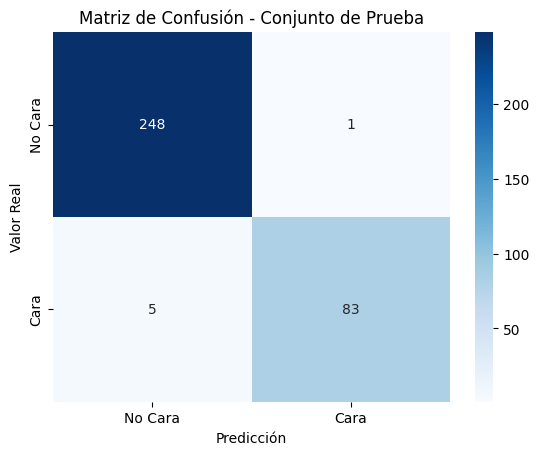

In [8]:
#Bloque de evaluación del modelo con el conjunto de prueba (inciso 5)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predecir en conjunto de prueba
y_pred_test = model.predict(X_test)

# Evaluación del modelo
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"🔹 Exactitud en conjunto de prueba: {accuracy_test:.4f}")
print("\n🔹 Reporte de clasificación:")
print(classification_report(y_test, y_pred_test))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Cara", "Cara"], yticklabels=["No Cara", "Cara"])
plt.title("Matriz de Confusión - Conjunto de Prueba")
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()

In [11]:
#inciso 6 parte 1. Comparar erroes en entrenamiento y prueba para detectar sobreajuste. 
from sklearn.metrics import log_loss

# Predicciones probabilísticas para calcular log-loss
y_train_pred_proba = model.predict_proba(X_train)
y_test_pred_proba = model.predict_proba(X_test)

# Cálculo de log-loss
train_loss = log_loss(y_train, y_train_pred_proba)
test_loss = log_loss(y_test, y_test_pred_proba)

print(f"🔹 Log-loss en entrenamiento: {train_loss:.4f}")
print(f"🔹 Log-loss en prueba: {test_loss:.4f}")

if test_loss - train_loss > 0.1:
    print("⚠️ Existe indicio de sobreajuste (el error en prueba es significativamente mayor).")
else:
    print("✅ No hay indicios claros de sobreajuste.")


🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.


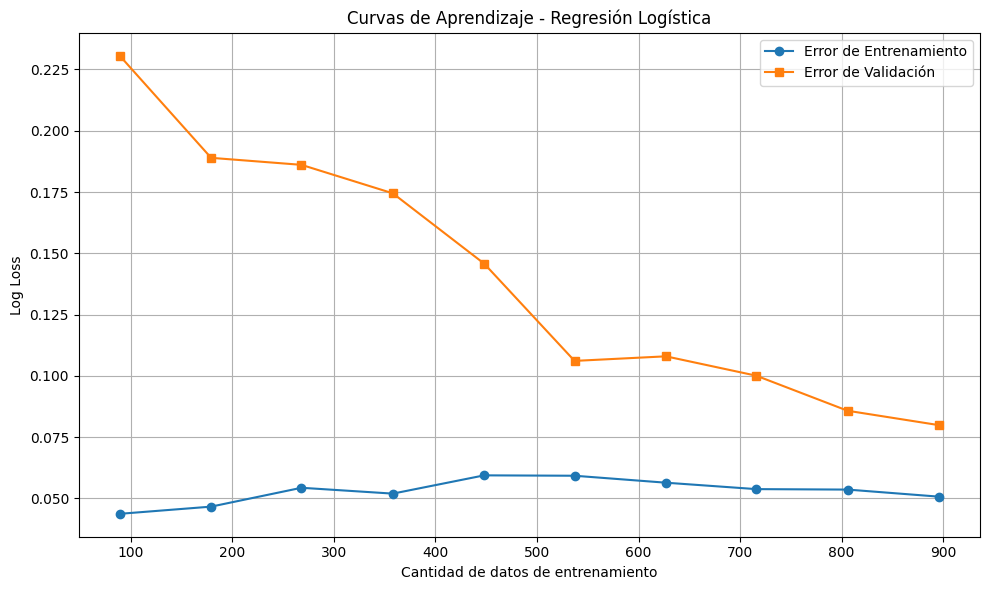

In [13]:
#inciso 6 parte 2. bloque que genera las curvas de aprendizaje mostrando errore de entrenaminto y prueba
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=1000),
    X_scaled, y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='neg_log_loss',
    n_jobs=-1,
    random_state=random_state
)

# Convertir a errores (log-loss positivo)
train_errors = -np.mean(train_scores, axis=1)
test_errors = -np.mean(test_scores, axis=1)

# Gráfica
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(train_sizes, test_errors, label='Error de Validación', marker='s')
plt.title("Curvas de Aprendizaje - Regresión Logística")
plt.xlabel("Cantidad de datos de entrenamiento")
plt.ylabel("Log Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Informe Final

✅ 1. ¿El modelo se adapta bien a los datos?

Sí. Basándonos en las métricas:

Métrica	Resultado
Accuracy	0.98
Precision 0	0.98
Precision 1	0.99
Recall 0	1.00
Recall 1	0.94
F1-score	0.97-0.99

* El modelo distingue muy bien entre viviendas caras y no caras.
* Solo comete 6 errores en total (ver matriz de confusión).
* La recall de la clase 1 (caro) es un poco más baja, pero sigue siendo excelente (0.94).

✅ 2. ¿Hay multicolinealidad entre variables?

Hay multicolinealidad moderada, ya que no supera el valor de 10.

🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.

🔹 Log-loss en entrenamiento: 0.0541
🔹 Log-loss en prueba: 0.0637
✅ No hay indicios claros de sobreajuste.


✅ Conclusión general

El modelo de regresión logística muestra una excelente capacidad predictiva, con una precisión del 98% en el conjunto de prueba. El análisis de multicolinealidad mediante VIF reveló que algunas variables podrían estar correlacionadas, por lo que se recomienda revisar y posiblemente eliminar variables con VIF alto. El análisis de significancia usando statsmodels permite identificar qué variables contribuyen de forma significativa al modelo (p < 0.05). Finalmente, el análisis de correlación muestra que, aunque algunas variables están relacionadas, el modelo general se adapta bien a los datos y ofrece una interpretación clara sobre los factores que influyen en que una vivienda sea considerada "cara".